In [1]:
import numpy as np
from tqdm import tqdm
import random, math
from sklearn.preprocessing import LabelBinarizer
from matplotlib import pyplot as plt


def accuracy_score(y_true, pred):
    return (y_true == pred).mean()*100
      
class SVM:
    
    def __init__(self, alpha=0.0001, C=1, preprocessors=[], patience=10):
        self.alpha=alpha
        self.C=C
        self.lb=LabelBinarizer()
        self.preprocessors=preprocessors
        self.patience=patience
        pass
    
    def earlystop(self, losses):
        if len(losses)<self.patience:
            return False
        return all(losses[-1] >= loss for loss in losses[-(self.patience+1):-1])
    
    def computeCost(self, condition):
         return np.maximum(0, 1-condition).mean() + np.linalg.norm(self.params)**2/self.C

    def _gen_batch(self, batch_size, no_of_samples, *args):
        i=0
        for j in range(math.ceil(no_of_samples/batch_size)):
            yield [arg[i:min(i+batch_size, no_of_samples)] for arg in args]
            i+=batch_size
            
    def plot(self, accuracies, losses):
        plt.style.use('dark_background')
        fig, ax =  plt.subplots(1,2, figsize=(10, 6))
        ax[0].plot(accuracies, color='yellow')
        ax[0].set_title('Accuracy Plot'), ax[0].set_xlabel('Epochs'), ax[0].set_ylabel('accuracy')
        ax[1].plot(losses, color='yellow')
        ax[1].set_title('Loss Plot'), ax[1].set_xlabel('Epochs'), ax[1].set_ylabel('loss')
        plt.show()
        
    def fit(self, X, Class, epochs=1000, batch_size=1, plot=True):
        
        alpha=self.alpha
        C=self.C
        
        X=np.array(X)
        for pp in self.preprocessors:
            X=pp.fit_transform(X)
            
        Class=np.array(Class)
        y=self.lb.fit_transform(Class)
        y=np.where(y<=0, -1, 1)
                
        num_of_samples, no_of_classes = y.shape
        biased_X=np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)
        self.params=np.random.rand(no_of_classes, X.shape[1]+1)  
        
        accuracies, losses = [], []
        pbar=tqdm(range(epochs), position=0, leave=True)
        for epoch in pbar:            
            indices=np.array(range(num_of_samples))
            random.shuffle(indices)
            biased_X = biased_X[indices]
            y = y[indices]
            
            for batch_biased_X, batch_y in self._gen_batch(batch_size, num_of_samples, biased_X, y):
                yhat = batch_biased_X @ self.params.T
                condition = yhat * batch_y
#                 cost=self.computeCost(condition)
                grad=-np.matmul(batch_y.T, batch_biased_X)
                grad[condition.mean(axis=0)>=1]=0
                delta_params= (2/C)*self.params + grad
                self.params=self.params-alpha*delta_params
            
            yhat = biased_X @ self.params.T
            cur_cost=np.maximum(0, 1-(yhat * y)).mean()
            yhatClass=self.lb.inverse_transform(np.where(yhat>=0, 1, 0))
            ytrue=self.lb.inverse_transform(y)
            accuracy=accuracy_score(ytrue, yhatClass)
            pbar.set_description("Accuracy {:.2f} Loss {:.2f}".format(accuracy, cur_cost))
            accuracies.append(accuracy), losses.append(cur_cost)
            if self.patience and self.earlystop(losses):
                print(f'Early stopping, loss traceback: {losses[-(self.patience+1):]}')
                break
        if plot:
            self.plot(accuracies, losses)
    
    def predict(self, Xpred):
        for pp in self.preprocessors:
            Xpred=pp.transform(Xpred)
        biased_Xpred=np.concatenate([np.ones((Xpred.shape[0], 1)), Xpred], axis=1)
        return biased_Xpred @ self.params.T
    
    def predict_classes(self, Xpred):
        pred=self.predict(Xpred)
        return self.lb.inverse_transform(np.where(pred>=0, 1, 0))
    
    def score(self, predX, y_true):
        pred=self.predict_classes(predX)
        return accuracy_score(y_true, pred)    

Accuracy 94.95 Loss 0.26:  36%|██████████████████▊                                  | 356/1000 [00:07<00:13, 47.51it/s]


Early stopping, loss traceback: [0.26364142597709156, 0.263640551164884, 0.26363880170627224, 0.2636384588724628, 0.2636582047483967, 0.2636569952357462, 0.2636763483409053, 0.2636549747640395, 0.2636736317183175, 0.26367254941524826, 0.26369085076792337]


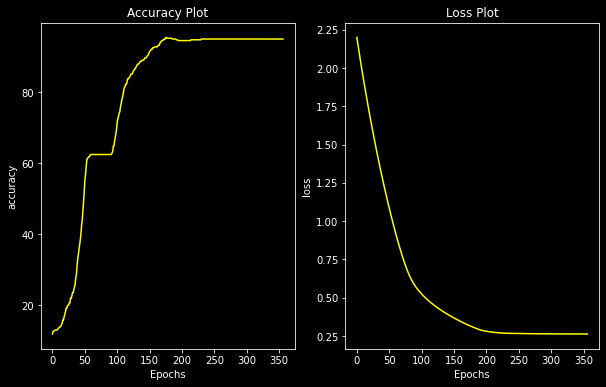

(95.6140350877193, 94.94505494505493)

In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer

X, y = load_breast_cancer(return_X_y=True)
trainX, testX, trainY, testY = train_test_split(X, y, random_state=28, test_size=0.2)

cls=SVM(C=10, preprocessors=[StandardScaler(), Normalizer()])
cls.fit(trainX, trainY)
cls.score(testX, testY), cls.score(trainX, trainY)

## Using Gaussian Kernel

In [124]:
def calc_kernel(row, ref_array):
    return np.apply_along_axis(lambda x : np.exp(
        -(np.linalg.norm(row-x)**2)/(2*ref_array.std())), 1, ref_array)
    
features=np.apply_along_axis(lambda row : calc_kernel(row, X), 1, X)
trainX, testX, trainY, testY = train_test_split(features, y, random_state=28, test_size=0.2)

cls=SVM()
cls.fit(trainX, trainY, epochs=1000, batch_size=32)
cls.score(testX, testY)